# Imaging at large angles

In [1]:
from pylab import *
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
import astropy.units as units
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
import time


%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
ls /data/craco/ban115/test_data/

ddgrid/                       frb_d0_t3_a1_sninf_lm00/      nant20@
frb_d0_t0_a1_sn10_lm00/       frb_d0_t4_a1_sninf_lm00/      nant3/
frb_d0_t0_a1_sninf_lm00/      frb_d0_t9_a1_sninf_lm00/      nant30/
frb_d0_t0_a1_sninf_lm100200/  frb_d2_t0_a1_sninf_lm00/      nant36/
frb_d0_t0_a2_sninf_lm00/      frb_d2_t4_a1_sn10_lm300400/   old_tranpose/
frb_d0_t1_a1_sninf_lm00/      frb_d2_t4_a1_sninf_lm300400/  transpose_31204/
frb_d0_t2_a1_sninf_lm00/      frb_d3_t7_a1_sninf_lm00/


In [3]:
#fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
fits = '/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm100200/frb_d0_t0_a1_sninf_lm100200.fits'
mirimage = '/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm100200/frb_d0_t0_a1_sninf_lm100200.fits.mir.imap.fits'

# PSR B1933+16 data
#fits = '/data/craco/ban115/craco-python/notebooks/data/SB049048v2/cap_spi16_bm0_a1-12_k1-6_ps_tsoff/results/b00.uvfits'

values = craco.search_pipeline.get_parser().parse_args([])
print(values)
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 2 --max-nbl 465 ")

Namespace(boxcar_weight='sum', calibration=None, cand_file='candidates.txt', device=0, dflag_cas_threshold=0, dflag_fradius=0, dflag_ics_threshold=0, dflag_tblk=None, dflag_tradius=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_input=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=0, flag_ants=[], flag_chans=None, flag_frequency_file=None, fov='1.1d', injection_file=None, input_scale=1.0, max_nbl=630.0, max_ndm=1024, metadata=None, nblocks=None, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', outdir='.', phase_center_filterbank=None, pickle_fname='pipeline.pickle', print_dm0_stats=False, run_fdmt=True, run_image=True, save=False, show=False, show_candidate_grid=None, show_fdmt=False, show_image=False, simulate_data=False, skip_blocks=0, start_mjd=None, stop_mjd=None, subtract=256, target_input_rms=512, threshold=6, update_uv_blocks=256, uv='uv_data', verb

/data/craco/ban115/craft-github/src/craft/uvfits.py:533: UserWarning: No BeamID in header. Filename not useful. Returning 0
  warnings.warn('No BeamID in header. Filename not useful. Returning 0')
/data/craco/ban115/craft-github/src/craft/uvfits.py:214: UserWarning: Unknown int time in file. returning 1ms
  warnings.warn('Unknown int time in file. returning 1ms')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=259.0 1-3 uvpix=(0, 2)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=515.0 2-3 uvpix=(1, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(1, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 

In [30]:
def pointsource(amp, lm, plan, noiseamp=0):
    '''
    Returns simulted visibilities for a point source with given amplitude at given value of lm =(l, m) in radians
    offset from the phase center
        
    :amp: amplitude
    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
    :plan: craco_plan to get all the goodies like UVWs and stuff from
    :noiseamp: add nois with tgiven ampliutude
    :returns: np.array of complex dtype with shape (nbl, nchan)
    '''
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    
    l, m = lm
    dout = np.empty((nbl, nf), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid])
        print(uvw_sec, type(uvw_sec))
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec['UU']*freqs
        v = uvw_sec['VV']*freqs
        w = uvw_sec['WW']*freqs

        # TMS equation 3.7 - don't include 1/sqrt(1 - l*l - m*m) denomiator term for point sources#
        # TMS has a minus sign
        # Andre Offringa's simulator has a plus sign
        # go figure?
        # Without the minus sign also matches miriad
        vis = amp*np.exp(2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        if noiseamp > 0:
            vishape = vis.shape
            noise = noiseamp*(np.random.randn(*vishape) + 1j*np.random.randn(*vishape))
            vis += noise

        dout[ibl, :] = vis

    return dout

In [31]:
plan.freqs = np.around(plan.freqs, -5)
plan.freqs

array([7.355e+08, 7.365e+08, 7.375e+08, 7.385e+08, 7.395e+08, 7.405e+08,
       7.415e+08, 7.425e+08, 7.435e+08, 7.445e+08, 7.455e+08, 7.465e+08,
       7.475e+08, 7.485e+08, 7.495e+08, 7.505e+08, 7.515e+08, 7.525e+08,
       7.535e+08, 7.545e+08, 7.555e+08, 7.565e+08, 7.575e+08, 7.585e+08,
       7.595e+08, 7.605e+08, 7.615e+08, 7.625e+08, 7.635e+08, 7.645e+08,
       7.655e+08, 7.665e+08, 7.675e+08, 7.685e+08, 7.695e+08, 7.705e+08,
       7.715e+08, 7.725e+08, 7.735e+08, 7.745e+08, 7.755e+08, 7.765e+08,
       7.775e+08, 7.785e+08, 7.795e+08, 7.805e+08, 7.815e+08, 7.825e+08,
       7.835e+08, 7.845e+08, 7.855e+08, 7.865e+08, 7.875e+08, 7.885e+08,
       7.895e+08, 7.905e+08, 7.915e+08, 7.925e+08, 7.935e+08, 7.945e+08,
       7.955e+08, 7.965e+08, 7.975e+08, 7.985e+08, 7.995e+08, 8.005e+08,
       8.015e+08, 8.025e+08, 8.035e+08, 8.045e+08, 8.055e+08, 8.065e+08,
       8.075e+08, 8.085e+08, 8.095e+08, 8.105e+08, 8.115e+08, 8.125e+08,
       8.135e+08, 8.145e+08, 8.155e+08, 8.165e+08, 

In [32]:
lm = (0,0.1)
# The fits files with lm100200 has l,m offsets of 100,200 arcseconds respecitvely. Let's see if we can reproduce it.
lmarcsec = np.array((100,200))
lm = np.sin(np.radians(lmarcsec/3600))
#lm=(0.01,0.02)
#lm = np.sin(np.radians([0.5,0.5]))
vissim = pointsource(1, lm, plan)
print('lm', lm)

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

<IPython.core.display.Javascript object>


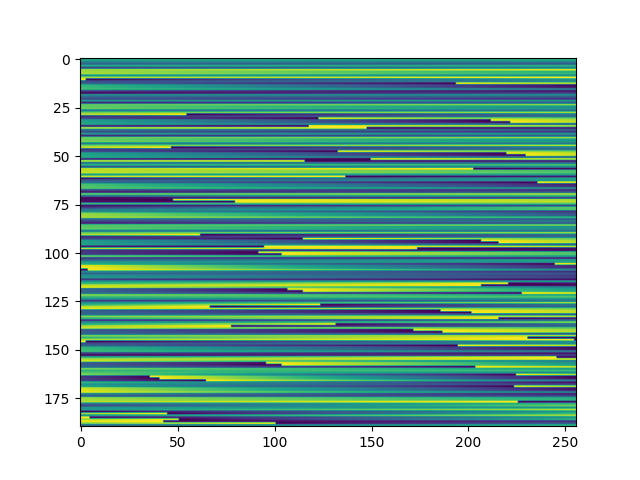

In [33]:
figure()
imshow(np.angle(vissim))

In [44]:
uvws = []
freqs = plan.freqs

for ibl, blid in enumerate(plan.baseline_order):       
    # baselines in seconds
    uvw_sec = np.array(plan.baselines[blid])

    # convert UVW coordinates to wavelegths
    u = uvw_sec['UU']*freqs
    v = uvw_sec['VV']*freqs
    w = uvw_sec['WW']*freqs
    uvws.append((u,v,w))
    
uvws = np.array(uvws)
uvws.shape

(190, 3, 256)

<IPython.core.display.Javascript object>


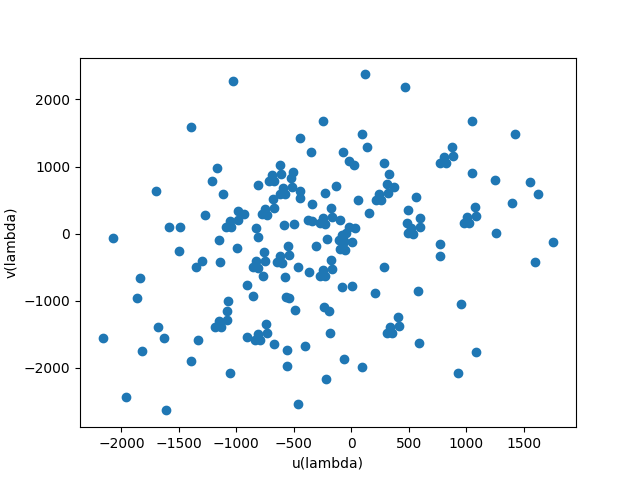

Text(0, 0.5, 'v(lambda)')

In [45]:
figure()
scatter(uvws[:,0,0],uvws[:,1,0])
xlabel('u(lambda)')
ylabel('v(lambda)')


<IPython.core.display.Javascript object>


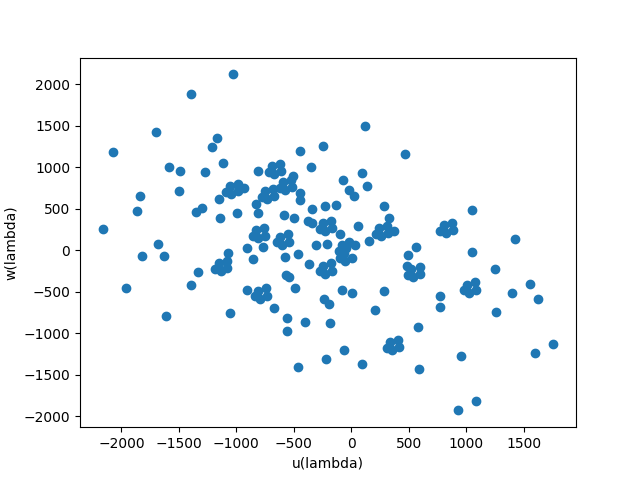

Text(0, 0.5, 'w(lambda)')

In [46]:
figure()
scatter(uvws[:,0,0],uvws[:,2,0])
xlabel('u(lambda)')
ylabel('w(lambda)')

<IPython.core.display.Javascript object>


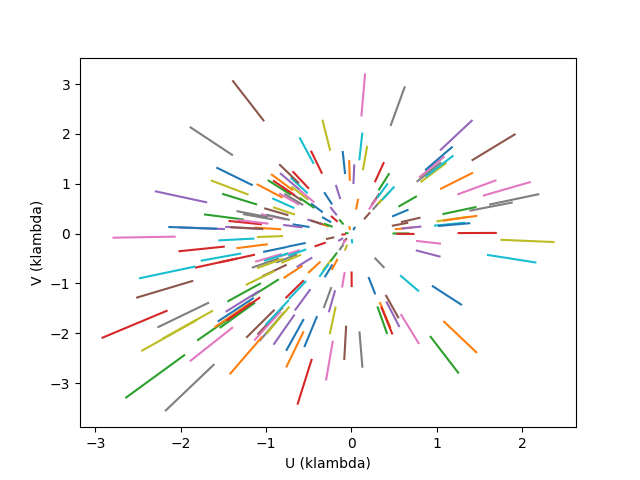

In [47]:
figure()
f.plot_baselines()

<IPython.core.display.Javascript object>


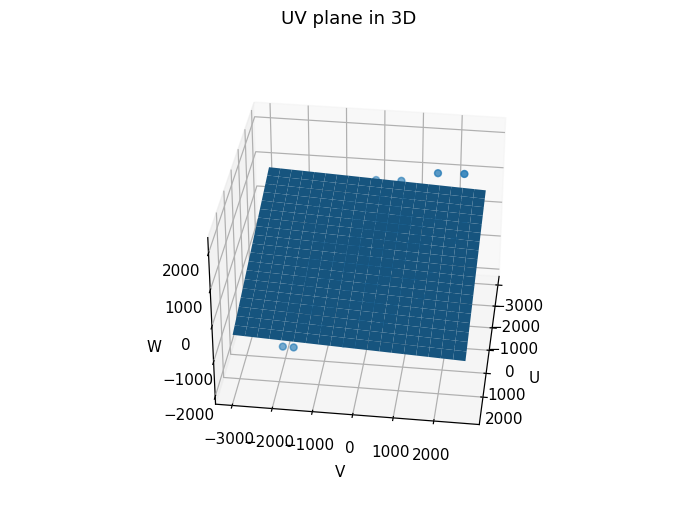

Text(0.5, 0.98, 'UV plane in 3D')

In [175]:
fig = figure()

ugrid = np.arange(-3000,3000,300)
vgrid= np.arange(-3000,3000,300)
U, V = np.meshgrid(ugrid,vgrid)
W = plan.craco_wcs.a*U + plan.craco_wcs.b*V
wprime = plan.craco_wcs.a*uvws[:,0,0] + plan.craco_wcs.b*uvws[:,1,0]

ax = fig.add_subplot(projection='3d')
ax.scatter(uvws[:,0,0],uvws[:,1,0],uvws[:,2,0])
ax.plot_surface(U,V,W)
#ax.plot_surface(U,V,plan.craco_wcs.a*U - plan.craco_wcs.b*V)
#ax.scatter(uvws[:,0,0],uvws[:,1,0],uvws[:,2,0]-wprime)

ax.set_xlabel('U')
ax.set_ylabel('V')
ax.set_zlabel('W')
fig.suptitle('UV plane in 3D')

In [174]:
plan.phase_center

<SkyCoord (ICRS): (ra, dec) in deg
    (0., -30.)>

In [53]:
plan.tstart

<Time object: scale='tai' format='isot' value=2020-06-09T00:00:00.000>

<IPython.core.display.Javascript object>


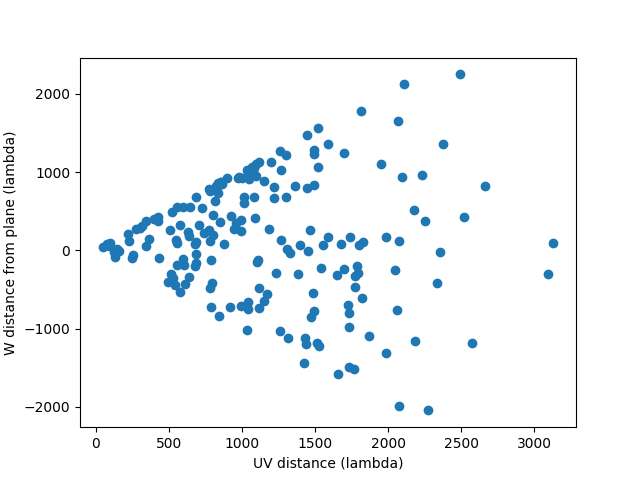

Text(0.5, 0, 'UV distance (lambda)')

In [54]:
figure()
plot(np.sqrt(uvws[:,0,0]**2 + uvws[:,1,0]**2), uvws[:,2,0]-wprime,'o')
ylabel('W distance from plane (lambda)')
xlabel('UV distance (lambda)')

In [56]:
plan.craco_wcs.a

0.22641974536819776

In [57]:
plan.craco_wcs.b

0.04493332908670229

In [58]:
ax.plot_surface?


In [59]:
f.baselines.keys()


dict_keys([258.0, 259.0, 515.0, 260.0, 516.0, 772.0, 261.0, 517.0, 773.0, 1029.0, 262.0, 518.0, 774.0, 1030.0, 1286.0, 263.0, 519.0, 775.0, 1031.0, 1287.0, 1543.0, 264.0, 520.0, 776.0, 1032.0, 1288.0, 1544.0, 1800.0, 265.0, 521.0, 777.0, 1033.0, 1289.0, 1545.0, 1801.0, 2057.0, 266.0, 522.0, 778.0, 1034.0, 1290.0, 1546.0, 1802.0, 2058.0, 2314.0, 267.0, 523.0, 779.0, 1035.0, 1291.0, 1547.0, 1803.0, 2059.0, 2315.0, 2571.0, 268.0, 524.0, 780.0, 1036.0, 1292.0, 1548.0, 1804.0, 2060.0, 2316.0, 2572.0, 2828.0, 269.0, 525.0, 781.0, 1037.0, 1293.0, 1549.0, 1805.0, 2061.0, 2317.0, 2573.0, 2829.0, 3085.0, 270.0, 526.0, 782.0, 1038.0, 1294.0, 1550.0, 1806.0, 2062.0, 2318.0, 2574.0, 2830.0, 3086.0, 3342.0, 271.0, 527.0, 783.0, 1039.0, 1295.0, 1551.0, 1807.0, 2063.0, 2319.0, 2575.0, 2831.0, 3087.0, 3343.0, 3599.0, 272.0, 528.0, 784.0, 1040.0, 1296.0, 1552.0, 1808.0, 2064.0, 2320.0, 2576.0, 2832.0, 3088.0, 3344.0, 3600.0, 3856.0, 273.0, 529.0, 785.0, 1041.0, 1297.0, 1553.0, 1809.0, 2065.0, 2321.0, 25

In [80]:
u,v,w = d['UU'],d['VV'],d['WW']
freqs = plan.freqs
ulam, vlam, wlam = u*freqs, v*freqs, w*freqs


In [81]:
idx = np.where(plan.baseline_order == blid)[0][0]
idx

0

In [88]:
vissim[idx,:].shape

(256,)

In [89]:
vissim.shape

(190, 256)

In [90]:
d.data.shape

()

In [93]:
f.hdulist[0].data['DATA'].shape

(3230, 1, 1, 256, 1, 3)

In [99]:
#if d.data.ndim == 6:
#    visc = d.data[0, 0, 0,:,0,0] + 1j*d.data[0, 0,0,:,0,1]
#else:
#    visc = d.data[0,0,:,0,0] + 1j*d.data[0,0,:,0,1]
    
visdata = f.hdulist[0].data['DATA']
if visdata.ndim == 7:
    allvis = visdata[:,0, 0,0,:,0,0] + 1j*visdata[:,0,0,0,:,0,1]
else:
    allvis = visdata[:, 0,0,:,0,0] + 1j*visdata[:,0,0,:,0,1]


In [100]:
allvis.shape

(3230, 256)

In [101]:
np.all(f.hdulist[0].data['BASELINE'] == plan.baseline_order)

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [102]:
#alldata = f.hdulist[0].data['DATA'][:,0,0,:,0,0] + 1j*f.hdulist[0].data['DATA'][:,0,0,:,0,1]
nbl = len(plan.baseline_order)
nchan=allvis.shape[1]
alldata = np.zeros((nbl, nchan), dtype=np.complex64)
blids = f.hdulist[0].data['BASELINE']
for i, ibl in enumerate(plan.baseline_order):
    idx = np.where(blids == ibl)[0][0]
    alldata[i, :] = allvis[idx, :]



In [103]:
blid = f.hdulist[0].data['BASELINE'][0]
blid

258.0

In [104]:
alldata.shape

(190, 256)

In [108]:
def grid(plan, din, uvcell, npix):
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
        
    g = np.zeros((npix,npix), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec['UU']*freqs
        v = uvw_sec['VV']*freqs
        #w = uvw_sec[2]*freqs
        
        #vis = np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        pivot = npix // 2
        upix = np.round(-u/uvcell[0] ).astype(int)
        vpix = np.round(v/uvcell[1] ).astype(int)
        for ichan, (up,vp) in enumerate(zip(upix,vpix)):
            g[pivot+vp,pivot+up] += din[ibl,ichan]
            g[pivot-vp,pivot-up] += np.conj(din[ibl,ichan])
        
        
    return g

def doimage(g):
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(g)))


def invimg(img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(img)))


# Does my point source function and miriad agree?


<IPython.core.display.Javascript object>


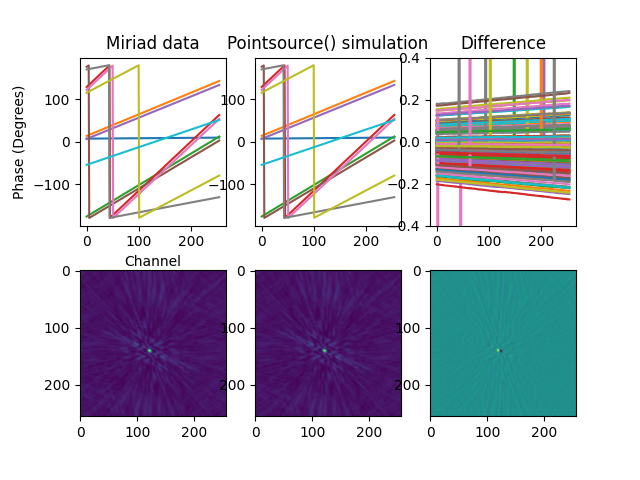

In [109]:

nant = 20
nbl = 20*19//2
fig,ax = subplots(2,3)
mir_img = doimage(grid(plan, alldata, plan.uvcell, plan.npix)).real
pointsource_grid = grid(plan, vissim, plan.uvcell, plan.npix)
pointsource_img = doimage(pointsource_grid).real

ax[0,0].plot(np.degrees(np.angle(alldata[-10:,:].T)))
ax[0,0].set_ylabel('Phase (Degrees)')
ax[0,0].set_xlabel('Channel')
ax[0,1].plot(np.degrees(np.angle(vissim[-10:].T)))
ax[0,0].set_title('Miriad data')
ax[0,1].set_title('Pointsource() simulation')
ax[0,2].plot(np.degrees(np.angle(alldata.T) - np.angle(vissim.T)))
ax[0,2].set_ylim(-0.4,0.4)
ax[0,2].set_title('Difference')

ax[1,0].imshow(mir_img)
ax[1,1].imshow(pointsource_img)
ax[1,2].imshow(mir_img - pointsource_img)



Filename: /data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm100200/frb_d0_t0_a1_sninf_lm100200.fits.mir.imap.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      89   (256, 256, 1, 1)   float32   


<IPython.core.display.Javascript object>


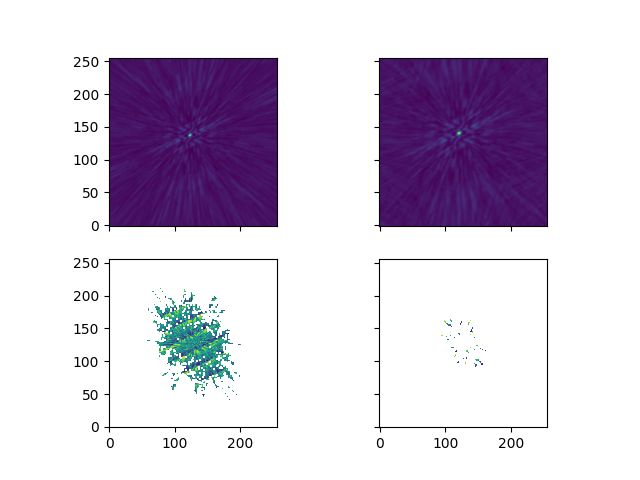

In [110]:
import astropy.io
mirimg = astropy.io.fits.open(mirimage)
mirimg.info()

fig,ax = subplots(2,2, sharex=True, sharey=True)

def angwhere(d, threshold=0.01):
    dout = np.angle(d)
    dout[abs(d) < threshold] = np.nan
    return dout

ax[0,0].imshow(mirimg[0].data[0,0,:,:], origin='lower')
ax[0,1].imshow(pointsource_img, origin='lower')

ax[1,0].imshow(angwhere(invimg(mirimg[0].data[0,0,:,:]), threshold=1e-5), origin='lower')
ax[1,1].imshow(angwhere(invimg(pointsource_img), threshold=1e-6), origin='lower')

In [112]:
plan.freqs[0]

735500000.0

In [113]:
f.hdulist[0].header

SIMPLE  =                    T  /                                               
BITPIX  =                  -32  /                                               
NAXIS   =                    6  /                                               
NAXIS1  =                    0  /                                               
NAXIS2  =                    3  /                                               
NAXIS3  =                    1  /                                               
NAXIS4  =                  256  /                                               
NAXIS5  =                    1  /                                               
NAXIS6  =                    1  /                                               
EXTEND  =                    T  /                                               
GROUPS  =                    T  /                                               
PCOUNT  =                    5  /                                               
GCOUNT  =                 32

In [114]:
! $MIRBIN/prthd in=/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm100200/frb_d0_t0_a1_sninf_lm100200.fits.mir/


prthd: Revision 1.10, 2012/03/02 06:13:02 UTC

****************************************************************
Filename: /data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm100200/frb_d0_t0_a1_sninf_lm100200.fits.mir/
Telescope: ASKAP
Object: frb_d0_t0_a1_sninf_lm100200.fits.mir
First time: 20JUN10:00:00:00.0
Number of antennae: 20
Polarisations Present: I
Type of correlations present: crosscorrelation
----------------------------------------------------------------
Spectral Correlations:
  Spectrum  Channels  Freq(chan=1)  Increment  Restfreq
      1        256       0.73550     0.001000   0.86300 GHz
  Total number of correlations: 826880
  Correlations are stored in 16-bit form

Continuum (wide) correlations:
  Corr No.  Frequency Bandwidth
      1       0.863    0.256000  GHz
  Total number of correlations: 3230
----------------------------------------------------------------
J2000    Source RA: 00:00:00.000  Dec: -30:00:00.00
Apparent Source RA: 00:00:00.000  Dec: -30:00:00.00

Hi

In [115]:
plan.tstart

<Time object: scale='tai' format='isot' value=2020-06-09T00:00:00.000>

In [116]:
# Miriad says the UVFITS file frequency channel 1 is 0.73550
# but the plan says
plan.freqs[0]

735500000.0

In [117]:
f.channel_frequencies[0]

735499993.944

In [118]:
from craft import craco
craco.get_freqs(f.hdulist)[0]

735499993.944

In [119]:
f.hdulist[0].header['CRPIX4']

1.0

In [120]:
f.hdulist[0].header['CRVAL4']

735499993.944

In [121]:
f.hdulist[0].header['CDELT4']

1000000.0475

In [122]:
from astropy import wcs
w = wcs.WCS(f.hdulist[0].header)

In [123]:
w

WCS Keywords

Number of WCS axes: 6
CTYPE : ''  'COMPLEX'  'STOKES'  'FREQ'  'RA'  'DEC'  
CRVAL : 0.0  1.0  1.0  735499993.944  0.0  -30.0  
CRPIX : 0.0  1.0  1.0  1.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4 PC1_5 PC1_6  : 1.0  0.0  0.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4 PC2_5 PC2_6  : 0.0  1.0  0.0  0.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4 PC3_5 PC3_6  : 0.0  0.0  1.0  0.0  0.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4 PC4_5 PC4_6  : 0.0  0.0  0.0  1.0  0.0  0.0  
PC5_1 PC5_2 PC5_3 PC5_4 PC5_5 PC5_6  : 0.0  0.0  0.0  0.0  1.0  0.0  
PC6_1 PC6_2 PC6_3 PC6_4 PC6_5 PC6_6  : 0.0  0.0  0.0  0.0  0.0  1.0  
CDELT : 1.0  1.0  1.0  1000000.0475  1.0  1.0  
NAXIS : 0  3  1  256  1  1

In [124]:
#w.pixel_to_world(0,0,0,0,0,0)[3]

<IPython.core.display.Javascript object>


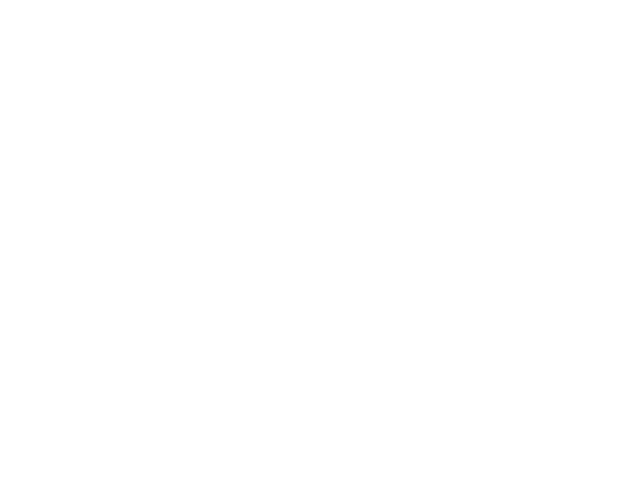

NameError: name 'visc' is not defined

In [125]:
figure()
plot(np.degrees(np.angle(visc)))
#plot(np.degrees(np.angle(np.conj(vissim[idx,:]))),'x')

<IPython.core.display.Javascript object>


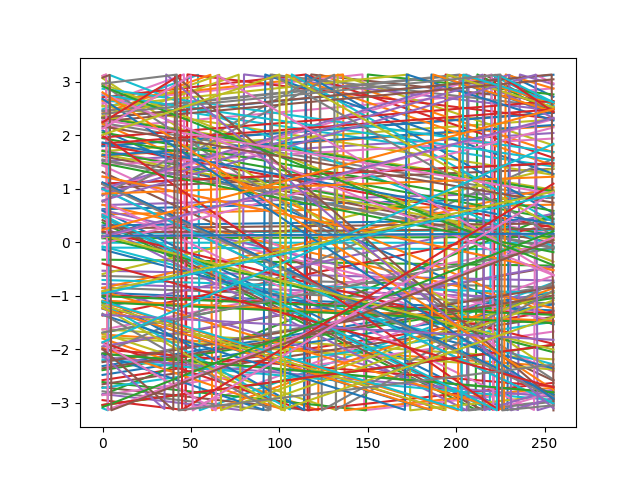

In [126]:
figure()
_ = plot(np.angle(vissim).T)

In [127]:
plan.uvcell

(52.087072284620284, 52.0870722846203)

lm=[0.01047178 0.012217  ]
(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'n

<IPython.core.display.Javascript object>


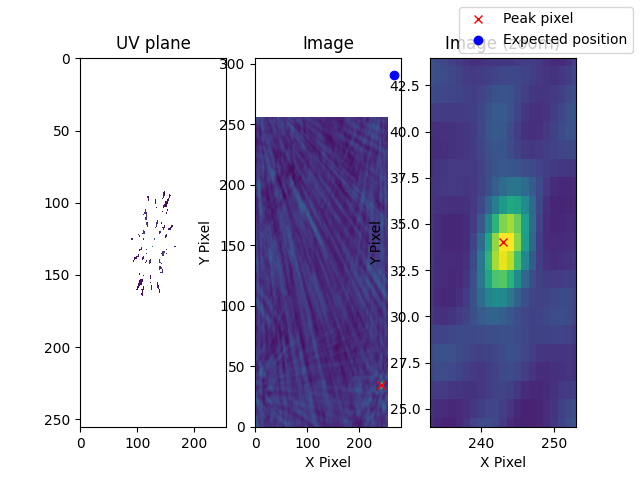

maxpix (34, 243)


In [128]:
# use plan cell size
uvcell = plan.uvcell

# use plan npix
npix=plan.npix

#    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
psi = Angle('0.6d') # offset degrees - RA direction
theta = Angle('0.7d') # offset degrees - dec direction
expected_dec = plan.phase_center.dec + theta # not sure why I need a negative here
# RA needs to be decremented by source cos dec
expected_ra = np.degrees(plan.phase_center.ra.rad - psi.rad/np.cos(expected_dec.rad))
expected_pos = SkyCoord(expected_ra, expected_dec, unit='deg')
# What did I expect the pixel location to be, given the expected position?
expected_pixel = plan.wcs.world_to_pixel(expected_pos)

lm = np.sin([psi.rad, theta.rad])
print(f'lm={lm}')
#lm=(0.01,0.02)
#lm = (0,0)
#lm = (0,0)
peak = 97280.0
vissim = pointsource(1, lm, plan)

fig,ax = subplots(1,3)
g = grid(plan, vissim, uvcell, npix)/np.prod(vissim.shape)/2 # Scales image to 1 for phase center
img = doimage(g)
gimg = abs(g)
gimg[gimg==0] = np.nan
maxpix = np.unravel_index(np.argmax(img.real), img.shape)
print('maxpix', maxpix)
ymax,xmax = maxpix
extents = (xmax -10, xmax+10, ymax-10, ymax+10)
#xtents=None
ax[0].imshow(gimg, aspect='auto')
ax[0].set_title("UV plane")

ax[1].imshow(img.real,aspect='auto', origin='lower')
ax[1].plot(xmax,ymax, 'rx')
ax[1].plot(expected_pixel[0], expected_pixel[1], 'bo')
ax[1].set_xlabel('X Pixel')
ax[1].set_ylabel('Y Pixel')
ax[1].set_title("Image")


ax[2].imshow(img.real,aspect='auto', origin='lower')
line1, = ax[2].plot(xmax,ymax, 'rx')
# (Because matplotlib pixels are centered on 0, we have to add 0.5 pixels) to get them to line up
# if you set the position to 0,0
line2, = ax[2].plot(expected_pixel[0]+0.5, expected_pixel[1]+0.5, 'bo') 
ax[2].set_xlabel('X Pixel')
ax[2].set_ylabel('Y Pixel')
ax[2].set_xlim(xmax-10,xmax+10)
ax[2].set_ylim(ymax-10,ymax+10)
ax[2].set_title("Image (zoom)")

figlegend((line1,line2),('Peak pixel','Expected position'))
        

<IPython.core.display.Javascript object>


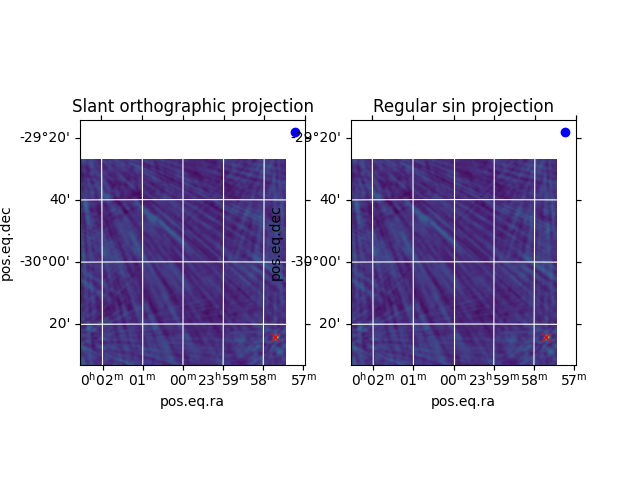

Text(0.5, 1.0, 'Regular sin projection')

In [130]:
from astropy.wcs import WCS
mywcs = WCS(naxis=2)
mywcs.wcs.crpix = [npix/2+1,npix/2+1] # honestly, I dont' understand if we need to +0.5 or not, or 1. 
mywcs.wcs.crval = [plan.phase_center.ra.deg, plan.phase_center.dec.deg]
mywcs.wcs.ctype = ['RA---SIN','DEC--SIN']
mywcs.wcs.cunit = ['deg','deg']
mywcs.wcs.cdelt = [-plan.lmcell[0].deg, plan.lmcell[1].deg]
import matplotlib.pyplot as plt
figure()

plt.subplot(1,2,1, projection=plan.wcs)
plt.imshow(img.real)
plt.grid(color='white', ls='solid')
plt.plot(xmax,ymax, 'rx')
plt.plot(expected_pixel[0], expected_pixel[1], 'bo')
plt.title('Slant orthographic projection')

plt.subplot(1,2,2,projection=mywcs)
plt.imshow(img.real)
plt.grid(color='white', ls='solid')
plt.plot(xmax,ymax, 'rx')
plt.plot(expected_pixel[0], expected_pixel[1], 'bo')
plt.title('Regular sin projection')


In [134]:
plan.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 0.0  -30.0  
CRPIX : 129.0  129.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.004296875  0.004296875  
NAXIS : 0  0

In [135]:
# there's some extra stuff in GETPV - that Steve Told me to put in to make it a slant orthographic projection
# see Ord et al. 2020 I t
plan.wcs.wcs.get_pv()

[(2, 1, 0.22641974536819776), (2, 2, -0.04493332908670229)]

In [136]:
# CRPIX is 128.5,128.5, but if you put do pixel_to_world(127.5,127.5) you get CRVAL back
# So there's a +-1 added because of the FITS convention. SIGH
plan.wcs.pixel_to_world(127.5,127.5)

<SkyCoord (ICRS): (ra, dec) in deg
    (0.00248083, -30.00214841)>

In [137]:
# similarly, wth the WCS as it stands, if you put in the phase center, what do you get?
# you get 127.5, 17.5
plan.wcs.world_to_pixel(plan.phase_center)

(array(128.), array(128.))

In [138]:
wcs_pos = plan.wcs.pixel_to_world(xmax-1,ymax-1) 
wcs_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (359.43109214, -30.40682889)>

In [139]:
expected_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (359.31198126, -29.3)>

In [140]:
ra_err = expected_pos.ra - wcs_pos.ra
ra_err

<Angle -0.11911088 deg>

In [141]:
dec_err = expected_pos.dec - wcs_pos.dec
dec_err

<Angle 1.10682889 deg>

In [142]:
# image resolution
plan.lmcell.arcsec

array([15.46875, 15.46875])

In [143]:
plan.wcs.world_to_pixel(expected_pos)

(array(267.2432939), array(290.4085089))

In [144]:
xmax, ymax

(243, 34)

In [145]:
# teh flat WCS is worse than plan.wcs, ish.
mywcs.world_to_pixel(expected_pos)

(array(267.63300781), array(290.4858482))

# Sweep in RA/Dec

In [146]:
#    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
expected_pixels = []
expected_pixels_flat = []
max_value = []

actual_pixels = []
angrange = np.arange(-0.7,0.7,0.1)
for psi in angrange:
    expected_pixels.append([])
    actual_pixels.append([]) 
    expected_pixels_flat.append([])
    max_value.append([])
    for theta in angrange:        
        psi = Angle(psi, unit='deg') # offset degrees - RA direction
        theta = Angle(theta,unit='deg') # offset degrees - dec direction
        expected_dec = plan.phase_center.dec + theta # not sure why I need a negative here
        expected_ra = np.degrees(plan.phase_center.ra.rad - psi.rad/np.cos(expected_dec.rad))
        expected_pos = SkyCoord(expected_ra, expected_dec, unit='deg')
        expected_pixel = plan.wcs.world_to_pixel(expected_pos)
        expected_pixel2 = mywcs.world_to_pixel(expected_pos)


        lm = np.sin([psi.rad, theta.rad])
        vissim = pointsource(1, lm, plan)
        g = grid(plan, vissim, uvcell, npix)/np.prod(vissim.shape)/2 # Scales image to 1 for phase center
        img = doimage(g)
        maxpix = np.unravel_index(np.argmax(img.real), img.shape)
        actual_pixels[-1].append(maxpix)
        expected_pixels[-1].append(expected_pixel)
        expected_pixels_flat[-1].append(expected_pixel2)
        max_value[-1].append(img.real.max())
        


(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

(3.9145537e-08, 1.1910919e-07, 9.1089056e-08) <class 'numpy.ndarray'>
(-2.2887711e-08, 1.2846125e-07, 1.3164093e-07) <class 'numpy.ndarray'>
(-1.0517931e-07, -1.934023e-08, 8.4034944e-08) <class 'numpy.ndarray'>
(-9.528239e-08, -1.9791852e-07, -3.9290335e-08) <class 'numpy.ndarray'>
(-3.361526e-07, 3.2404543e-07, 4.414731e-07) <class 'numpy.ndarray'>
(3.2882699e-07, 8.0185777e-07, 3.6251456e-07) <class 'numpy.ndarray'>
(7.1171837e-07, 1.2161054e-07, -3.097513e-07) <class 'numpy.ndarray'>
(-3.3177986e-07, -7.3803056e-07, -2.5066635e-07) <class 'numpy.ndarray'>
(-8.385375e-07, -4.5861415e-07, 2.2537502e-07) <class 'numpy.ndarray'>
(-1.0182226e-06, 5.084548e-07, 9.681098e-07) <class 'numpy.ndarray'>
(-8.0411246e-07, 9.2217556e-07, 1.1151492e-06) <class 'numpy.ndarray'>
(1.0928538e-06, 1.5501732e-06, 4.1014346e-07) <class 'numpy.ndarray'>
(1.3726631e-06, 3.3812051e-07, -5.6379724e-07) <class 'numpy.ndarray'>
(4.594754e-07, -1.8953649e-06, -1.504442e-06) <class 'numpy.ndarray'>
(-1.1012177e

In [147]:
expected_pixels = np.array(expected_pixels)
expected_pixels_flat = np.array(expected_pixels_flat)

actual_pixels = np.array(actual_pixels)

In [148]:
expected_pixels.shape

(14, 14, 2)

In [149]:
actual_pixels.shape

(14, 14, 2)

In [150]:
expected_pixels[0,0,:]

array([-35.35586602, -35.57345736])

In [151]:
actual_pixels[0,0,:] # is transposed because of how unravel index works

array([220,  34])

<IPython.core.display.Javascript object>


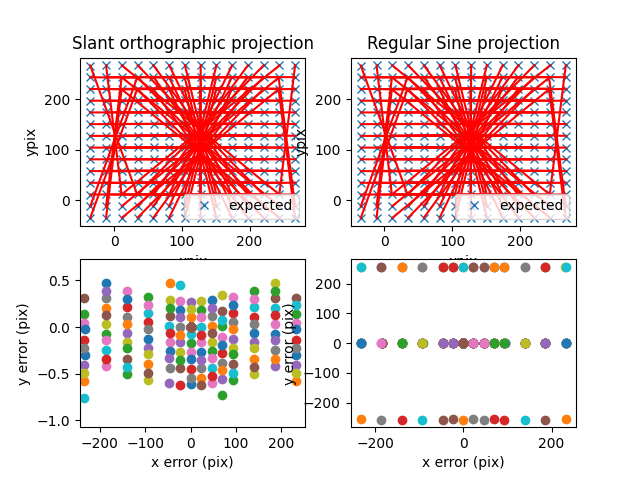

Text(0.5, 1.0, 'Regular Sine projection')

In [152]:

def plot_diff(ax, expected_pixels, actual_pixels):
    ax[0].plot(expected_pixels[...,0].flatten(), expected_pixels[...,1].flatten(), 'x', label='expected')
    for i in range(np.array(actual_pixels.shape[0:2]).prod()): 
        x1 = expected_pixels[...,0].flatten()[i]
        y1 = expected_pixels[...,1].flatten()[i]
        x2 = actual_pixels[...,1].flatten()[i]
        y2 = actual_pixels[...,0].flatten()[i]
        ax[0].plot([x1,x2],[y1,y2],'r')
        ax[1].plot([0,x2-x1],[0,y2-y1],'o')
        
        
    ax[0].set_xlabel('xpix')
    ax[0].set_ylabel('ypix')
    ax[1].set_xlabel('x error (pix)')
    ax[1].set_ylabel('y error (pix)')
    ax[0].legend()


fig, ax = subplots(2,2)
plot_diff(ax[:,0], expected_pixels, actual_pixels)
plot_diff(ax[:,1], expected_pixels_flat, actual_pixels)
ax[0,0].set_title('Slant orthographic projection')
ax[0,1].set_title('Regular Sine projection')



<IPython.core.display.Javascript object>


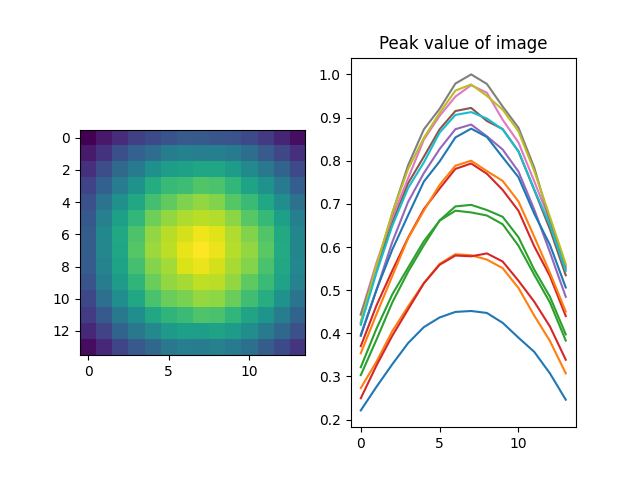

Text(0.5, 1.0, 'Peak value of image')

In [153]:
fig, ax = subplots(1,2)
ax[0].imshow(max_value)
ax[1].plot(max_value)
title('Peak value of image')

<IPython.core.display.Javascript object>


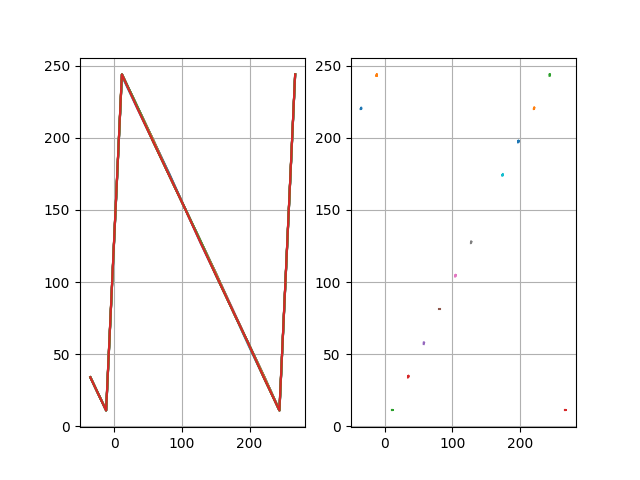

In [154]:
fig,ax = subplots(1,2)
ax[0].plot(expected_pixels[...,0],actual_pixels[...,1])
ax[1].plot(expected_pixels[...,1],actual_pixels[...,0])
ax[0].grid(True)
ax[1].grid(True)


# Doing something else - check what changing cell size does to peak value

In [155]:


for c in (2,5,10,15,20,30,40):
    for npix in (256,512,1024,2048,4096):
        uvcell=(c,c)
        try:
            g = grid(plan, vissim, uvcell, npix)
            img = doimage(g)
            print(f'c={c} npix={npix} max={img.real.max()/peak}')
        except:
            print(f'Couldnt grid c={c} npix={npix}')
        

Couldnt grid c=2 npix=256
Couldnt grid c=2 npix=512
Couldnt grid c=2 npix=1024
Couldnt grid c=2 npix=2048
c=2 npix=4096 max=0.9418655623388295
Couldnt grid c=5 npix=256
Couldnt grid c=5 npix=512
Couldnt grid c=5 npix=1024
c=5 npix=2048 max=0.9346985424176736
c=5 npix=4096 max=0.9886848801553652
Couldnt grid c=10 npix=256
Couldnt grid c=10 npix=512
c=10 npix=1024 max=0.9105409286417084
c=10 npix=2048 max=0.962580029110288
c=10 npix=4096 max=0.9625800291102882
Couldnt grid c=15 npix=256
c=15 npix=512 max=0.9086766502059019
c=15 npix=1024 max=0.9086766502059019
c=15 npix=2048 max=0.9151518023932986
c=15 npix=4096 max=0.9202919213434819
Couldnt grid c=20 npix=256
c=20 npix=512 max=0.8148239100728216
c=20 npix=1024 max=0.8610019506002261
c=20 npix=2048 max=0.8610019506002261
c=20 npix=4096 max=0.8633035967779299
c=30 npix=256 max=0.7022329989520295
c=30 npix=512 max=0.7022329989520295
c=30 npix=1024 max=0.7067156159117775
c=30 npix=2048 max=0.7108353259231686
c=30 npix=4096 max=0.7112001974

In [156]:
sum(abs(vissim))

48640.0

In [157]:
np.prod(vissim.shape)

48640

In [162]:
def degrid(plan, lm, uvcell):
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    l,m = lm
        
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    
    l, m = lm
    dout = np.empty((nbl, nf), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec['UU']*freqs
        v = uvw_sec['VV']*freqs
        w = uvw_sec['WW']*freqs
        
        #vis = np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        if uvcell is not None:
            u = np.round(u/uvcell[0])*uvcell[0]
            v = np.round(v/uvcell[1])*uvcell[1]
            
        devis = np.exp(-2j*np.pi*(u*l + v*m + 0*w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        dout[ibl,:] = devis
    return dout

vissimdg = degrid(plan,lm,uvcell=None)
print(np.sum(np.conj(vissimdg)*vissim)/np.prod(vissim.shape))

(0.018362480715701453-0.00526077621861508j)


<IPython.core.display.Javascript object>


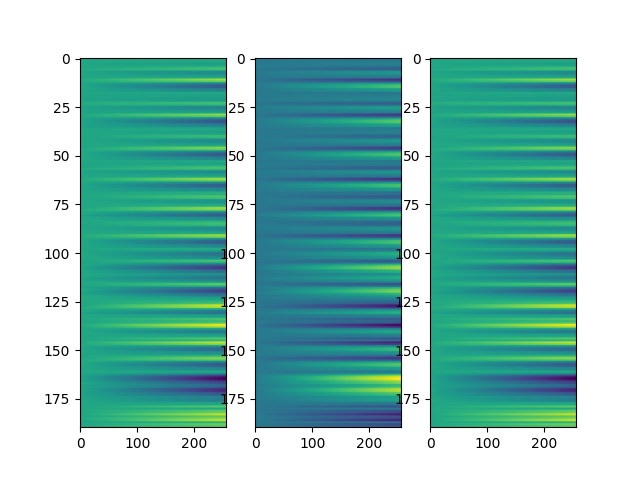

In [163]:
def myang(d):
    return np.degrees(np.unwrap(np.angle(d)))
fig,ax = subplots(1,3)
ax[0].imshow(myang(vissim), aspect='auto')
ax[1].imshow(myang(vissimdg), aspect='auto')
ax[2].imshow(myang(vissim) - myang(vissimdg), aspect='auto')


<IPython.core.display.Javascript object>


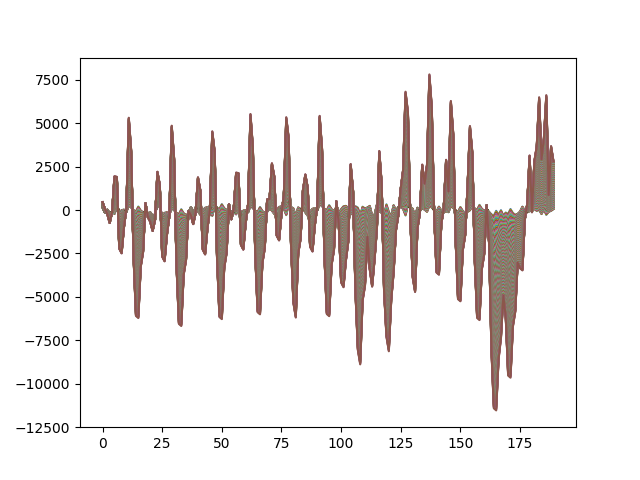

In [165]:
figure()
x = myang(vissim) - myang(vissimdg)
plot(x)

In [166]:
r = plan.fdmt_plan.runs[100]
r

ncells=8 fch1=799500000.0 chan_start=64 total_overlap=256

In [167]:
r.cells

[Cell blid=1803.0 chan=64-95 freq=799.50-830.50 uvpix=(21, 251) upper_idx=1500 uvpix_upper=(235, 5),
 Cell blid=4370.0 chan=64-95 freq=799.50-830.50 uvpix=(249, 19) upper_idx=4923 uvpix_upper=(249, 19),
 Cell blid=516.0 chan=64-95 freq=799.50-830.50 uvpix=(2, 254) upper_idx=763 uvpix_upper=(254, 2),
 Cell blid=258.0 chan=64-95 freq=799.50-830.50 uvpix=(255, 2) upper_idx=764 uvpix_upper=(255, 2),
 Cell blid=772.0 chan=64-95 freq=799.50-830.50 uvpix=(1, 254) upper_idx=764 uvpix_upper=(255, 2),
 Cell blid=4113.0 chan=64-95 freq=799.50-830.50 uvpix=(7, 4) upper_idx=1021 uvpix_upper=(7, 4),
 Cell blid=262.0 chan=64-95 freq=799.50-830.50 uvpix=(5, 5) upper_idx=1270 uvpix_upper=(5, 5),
 Cell blid=773.0 chan=64-95 freq=799.50-830.50 uvpix=(1, 251) upper_idx=1520 uvpix_upper=(255, 5)]